# Определение стоимости автомобилей

**Задача:**<br>
Построить модель для определения рыночной стоимости автомобиля по следующим известным характеристикам:
- Марка автомобиля<br>
- Модель автомобиля<br>
- Год регистрации автомобиля<br>
- Тип коробки передач<br>
- Мощность (л. с.)<br>
- Пробег (км)<br>
- Тип топлива<br>
- Была машина в ремонте или нет<br>

**Дано:**<br>
Исторические данные: технические характеристики, комплектации и цены автомобилей.

**Ход работы:**<br>
1. Провести анализ данных
2. Подготовить данные для обучения моделей
3. Обучить несколько моделей и сравнить их хаарктеристики:
    - Качество предсказания
    - Скорость предсказания
    - Время обучения

## Подготовка данных

In [3]:
#Импортируем библиотеки и модули
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV,
    train_test_split,
    cross_val_score
)

from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

In [4]:
#Загружаем датафрейм
df = pd.read_csv('/datasets/autos.csv')

In [5]:
df.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


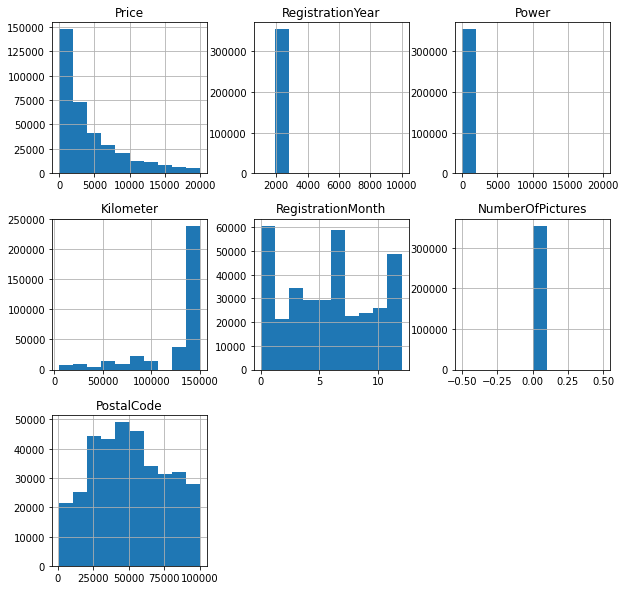

In [6]:
#Строим гистограммы столбцов
df.hist(figsize=(10, 10));

In [7]:
#Выводим информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Типы столбцов указаны корректно, за исключением 'DateCrawled', 'DateCreated'. Для данной задачи это не информативные признаки и они не будут использоваться для обучения моделей, поэтому не изменяем тип этих столбцов.

In [8]:
#Проверим на явные дубликаты
print(df.duplicated().sum())

4


In [9]:
#Удалим дубликаты
df.drop_duplicates(inplace=True)

In [10]:
#Проверим на пропуски
pd.DataFrame(df.isna().mean()).sort_values(by=0, ascending=False).style.background_gradient('coolwarm')

,0
Repaired,0.200793
VehicleType,0.105795
FuelType,0.092828
Gearbox,0.055968
Model,0.055607
DateCrawled,0.000000
Price,0.000000
RegistrationYear,0.000000
Power,0.000000
Kilometer,0.000000


**Работа с пропусками**

**Столбец 'Model'**

In [11]:
#Выведем уникальные значения столбца 'Model'
df['Model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

Заполнить пропуски в столбце 'Model' можно либо 'other', либо самой популярной моделью для каждой марки из столбца 'Brand'. Посмотрим, какую долю для каждой марки составляет самая популярная модель и модель 'other'.

In [12]:
#Какую долю в среднем составляет самая популярная модель для каждой марки
brands = []
for brand in df['Brand'].unique():
    try:
        brands.append(df.loc[df['Brand'] == brand, 'Model'].value_counts()[0]/ \
                      df.loc[df['Brand'] == brand, 'Model'].value_counts().sum())
    except IndexError:
        brands.append(0)
    
print('Средняя доля самой популярной модели для всех марок:')
pd.Series(brands).median()

Средняя доля самой популярной модели для всех марок:


0.3707779199009421

In [13]:
#Какую долю составляет модель 'other' для каждой марки
brands = []
for brand in df['Brand'].unique():
    try:
        brands.append(df.loc[df['Brand'] == brand, 'Model'].value_counts()['other']/ \
                      df.loc[df['Brand'] == brand, 'Model'].value_counts().sum())
    except KeyError:
        brands.append(0)
    
print('Средняя доля модели "other" для всех марок:')
pd.Series(brands).median()

Средняя доля модели "other" для всех марок:


0.167644802141831

**Вывод**: Заменим пропуски в столбце 'Model' самой популярной моделью для каждой марки, т.к. вероятность того, что пропуск окажется самой популярной моделью выше более чем в 2 раза в сравнении с моделью 'other'

In [14]:
#Заполняем пропуски
for brand in df['Brand'].unique():
    try:
        df.loc[(df['Brand'] == brand) & (df['Model'].isna()), 'Model'] = \
        df.loc[df['Brand'] == brand, 'Model'].value_counts().index[0]
    except IndexError:
        df.loc[(df['Brand'] == brand) & (df['Model'].isna()), 'Model'] = 'other'

**Столбец 'Repaired'**

In [15]:
#Выведем уникальные значения столбца 'Repaired'
df['Repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

Вероятно, пропуск означает значение 'no'. Заменим пропуски на это значение

In [16]:
#Заменим пустые значения на 'no'
df['Repaired'] = df['Repaired'].fillna('no')

**Столбец 'VehicleType'**

In [17]:
#Выведем уникальные значения столбца 'VehicleType'
df['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

Заполнить пропуски в столбце 'VehicleType' можно либо 'other', либо самым популярным типом кузова для каждой модели из столбца 'Model'. Посмотрим, какую долю для каждой модели составляет самый популярный тип кузова и тип кузова 'other'.

In [18]:
#Какую долю в среднем составляет самый популярный тип кузова для всех моделей
vehicle_types = []
for model in df['Model'].unique():
    vehicle_types.append(df.loc[df['Model'] == model, 'VehicleType'].value_counts()[0]/ \
          df.loc[df['Model'] == model, 'VehicleType'].value_counts().sum())
    
print('Средняя доля самого популярного типа кузова для всех марок:')
pd.Series(vehicle_types).median()

Средняя доля самого популярного типа кузова для всех марок:


0.8326569264069263

In [19]:
#Какую долю в среднем составляет тип кузова 'other' для всех моделей
vehicle_types = []
for model in df['Model'].unique():
    try:
        vehicle_types.append(df.loc[df['Model'] == model, 'VehicleType'].value_counts()['other']/ \
          df.loc[df['Model'] == model, 'VehicleType'].value_counts().sum())
    except KeyError:
        vehicle_types.append(0)
    
print('Средняя доля самого типа кузова "other" для всех марок:')
pd.Series(vehicle_types).median()

Средняя доля самого типа кузова "other" для всех марок:


0.0029832218796300002

**Вывод**: Заменим пропуски в столбце 'VehicleType' самым популярным типом кузова для каждой модели, т.к. вероятность того, что пропуск окажется самый популярным типом кузова выше в 270 раз в сравнении с типом кузова 'other'

In [20]:
#Заполняем пропуски
for model in df['Model'].unique():
    df.loc[(df['Model'] == model) & (df['VehicleType'].isna()), 'VehicleType'] = \
    df.loc[df['Model'] == model, 'VehicleType'].value_counts().index[0]

**Столбец 'Gearbox'**

In [21]:
#Выведем уникальные значения столбца
df['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [22]:
#Выведем количество цникальных значений
df['Gearbox'].value_counts(dropna=False)

manual    268249
auto       66283
NaN        19833
Name: Gearbox, dtype: int64

Заполним пропуски значением 'manual', т.к., во-первых, вероятность такого значения на месте пропуска выше по сравнению с 'auto', во-вторых, вероятно, значение 'auto' нужно было специально указать и продавец мог этого не сделать.

In [23]:
#Заменим пропуски на 'manual'
df['Gearbox'] = df['Gearbox'].fillna('manual')

**Столбец 'FuelType'**

In [24]:
#Выведем уникальные значения столбца
df['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [25]:
#Выведем количество уникальных значений
df['FuelType'].value_counts(dropna=False)

petrol      216349
gasoline     98719
NaN          32895
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

In [26]:
#Заменим пропуски на 'petrol'
df['FuelType'] = df['FuelType'].fillna('petrol')

Категории petrol и gasoline обозначают бензиновый тип двигателя, поэтому объединим их в один тип - petrol

In [27]:
df.loc[df['FuelType'] == 'gasoline', 'FuelType'] = 'petrol'

**Поиск аномалий в столбцах**

In [28]:
#Вывеедм числовое описание данных
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


**Столбец 'Price'**

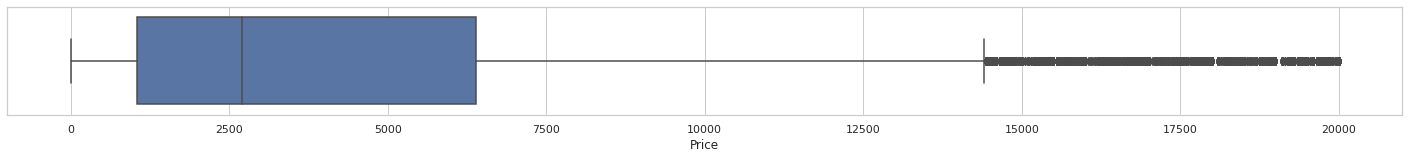

In [29]:
#Построим диаграмму "ящик с усами"
plt.figure(figsize =(25, 2))
sns.set(style="whitegrid")
sns.boxplot(df['Price']);

In [30]:
#Выведем формулы для подсчёта верхней и нижней границы "усов"
column = 'Price'
max = df.describe()[column]['75%'] + (df.describe()[column]['75%'] - df.describe()[column]['25%'])*1.5
min = df.describe()[column]['25%'] - (df.describe()[column]['75%'] - df.describe()[column]['25%'])*1.5

In [31]:
#Выведем долю объектов с Price = 0
len(df.query('Price == 0'))/len(df)

0.030398035923412302

In [32]:
#Заполняем значения Price = 0 медианой для каждой модели
for model in df['Model'].unique():
    df.loc[(df['Model'] == model) & (df['Price'] == 0), 'Price'] = \
    df.loc[(df['Model'] == model) & (df['Price'] != 0), 'Price'].median()

In [33]:
#Выведем количество уникальных значений столбца
df['Price'].value_counts().head(20)

500.0     5670
1500.0    5573
3500.0    4894
1000.0    4772
1200.0    4757
2500.0    4553
600.0     3825
800.0     3812
2800.0    3534
2000.0    3447
1800.0    3437
999.0     3391
4500.0    3209
750.0     3206
650.0     3159
900.0     2989
950.0     2979
850.0     2975
2200.0    2936
700.0     2936
Name: Price, dtype: int64

In [34]:
#Вывеедм процент объектов с признаком Price меньше 499
len(df.query('Price < 499'))/len(df)*100

6.9453811747774195

In [35]:
df.query('Price < 499')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480.0,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,no,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
15,2016-03-11 21:39:15,450.0,small,1910,manual,0,ka,5000,0,petrol,ford,no,2016-03-11 00:00:00,0,24148,2016-03-19 08:46:47
16,2016-04-01 12:46:46,300.0,small,2016,manual,60,polo,150000,0,petrol,volkswagen,no,2016-04-01 00:00:00,0,38871,2016-04-01 12:46:46
23,2016-03-12 19:43:07,450.0,small,1997,manual,50,arosa,150000,5,petrol,seat,no,2016-03-12 00:00:00,0,9526,2016-03-21 01:46:11
32,2016-03-15 20:59:01,245.0,sedan,1994,manual,0,golf,150000,2,petrol,volkswagen,no,2016-03-15 00:00:00,0,44145,2016-03-17 18:17:43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354309,2016-03-09 22:37:41,99.0,small,1999,manual,60,arosa,150000,1,petrol,seat,yes,2016-03-09 00:00:00,0,91301,2016-04-06 22:15:32
354318,2016-03-15 19:57:11,400.0,wagon,1991,manual,0,legacy,150000,0,petrol,subaru,no,2016-03-15 00:00:00,0,24558,2016-03-19 15:49:00
354329,2016-03-30 20:55:30,350.0,small,1996,manual,65,punto,150000,0,petrol,fiat,no,2016-03-30 00:00:00,0,25436,2016-04-07 13:50:41
354335,2016-04-04 14:41:28,390.0,small,1997,auto,0,corsa,100000,6,petrol,opel,yes,2016-04-04 00:00:00,0,17509,2016-04-06 15:46:11


In [36]:
#Домножим значение Price у этих объектов на 10
df.loc[df['Price'] < 499, 'Price'] = df.loc[df['Price'] < 499, 'Price']*10

In [37]:
#Оставшиеся объекты с ценами меньше 499 удаляем
df = df.query('Price > 499')

Рассмотрим выбросы с Price больше 14000

In [38]:
#Доля выбросов
len(df.query('Price > @max'))/len(df)*100

5.400760702527816

In [39]:
df.query('Price > @max')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1,2016-03-24 10:58:45,18300.0,coupe,2011,manual,190,a4,125000,5,petrol,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
8,2016-04-04 23:42:13,14500.0,bus,2014,manual,125,c_max,30000,8,petrol,ford,no,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
14,2016-03-21 12:57:01,17999.0,suv,2011,manual,190,navara,70000,3,petrol,nissan,no,2016-03-21 00:00:00,0,4177,2016-04-06 07:45:42
33,2016-03-25 21:48:47,18000.0,sedan,2007,auto,218,3er,20000,5,petrol,bmw,no,2016-03-25 00:00:00,0,39179,2016-04-07 04:45:21
50,2016-03-30 08:50:37,14800.0,convertible,2008,manual,170,1er,125000,4,petrol,bmw,no,2016-03-30 00:00:00,0,48691,2016-04-07 00:17:23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354259,2016-03-22 15:53:41,15000.0,sedan,2013,auto,115,focus,60000,10,petrol,ford,no,2016-03-22 00:00:00,0,24340,2016-03-31 13:47:54
354279,2016-03-11 11:59:21,16500.0,suv,2013,manual,116,i_reihe,30000,9,petrol,hyundai,no,2016-03-11 00:00:00,0,76297,2016-04-07 06:16:09
354286,2016-03-21 20:44:38,16500.0,coupe,1973,manual,200,other,150000,6,petrol,bmw,yes,2016-03-21 00:00:00,0,74722,2016-04-06 19:16:32
354306,2016-04-02 23:25:40,16999.0,wagon,2008,auto,269,a6,150000,7,petrol,audi,no,2016-04-02 00:00:00,0,61440,2016-04-06 15:17:04


**Столбец 'RegistrationYear'**

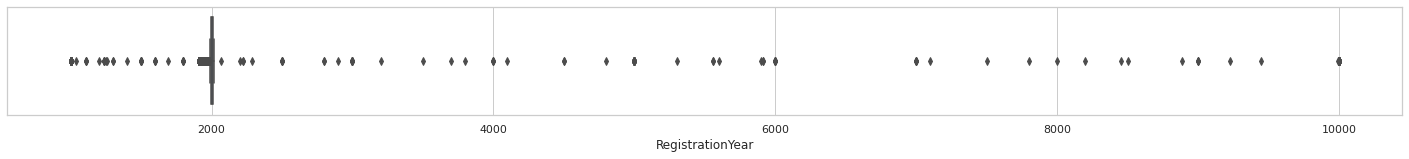

In [40]:
#Построим boxplot
plt.figure(figsize =(25, 2))
boxplot = sns.boxplot(df['RegistrationYear']);
#boxplot.set_xlim(1900, 2021);

In [41]:
#Найдём верхние и нижние границы усов
column = 'RegistrationYear'
max = df.describe()[column]['75%'] + (df.describe()[column]['75%'] - df.describe()[column]['25%'])*1.5
min = df.describe()[column]['25%'] - (df.describe()[column]['75%'] - df.describe()[column]['25%'])*1.5
print(max)
print(min)

2021.5
1985.5


In [42]:
#Выведем процент объектов с RegistrationYear больше верхней и нижней границ усов
print(len(df.query('RegistrationYear >@max'))/len(df)*100)
len(df.query('RegistrationYear <@min'))/len(df)*100

0.028405620904264538


1.7270617509792838

В обоих случаях % < 5, можно удалить объекты

In [43]:
#Удаляем объекты с RegistrationYear больше верхней границы
df = df.query('RegistrationYear < @max')
#Удаляем объекты с RegistrationYear меньше нижней границы
df = df.query('RegistrationYear > @min')

**Столбец 'Power'**

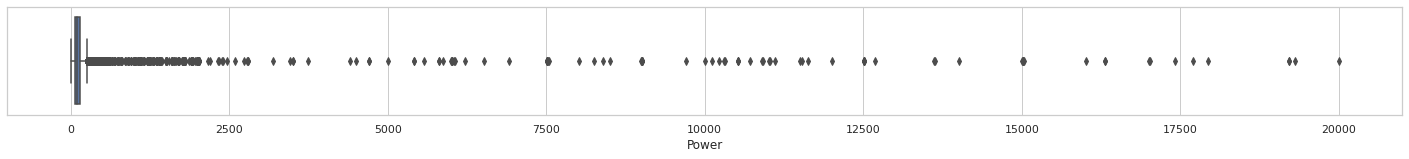

In [44]:
#Строим "ящик с усами"
plt.figure(figsize =(25, 2))
sns.boxplot(df['Power']);#.set_xlim(-10, 3000);

In [45]:
#Формулы для подсчёта верхней и нижней границы "усов"
column = 'Power'
max = df.describe()[column]['75%'] + (df.describe()[column]['75%'] - df.describe()[column]['25%'])*1.5
min = df.describe()[column]['25%'] - (df.describe()[column]['75%'] - df.describe()[column]['25%'])*1.5
print(min)
print(max)

-42.0
254.0


In [46]:
#Выведем столбец впорядке убывания
df['Power'].sort_values()

0             0
295156        0
201491        0
295154        0
295149        0
          ...  
63986     17932
132485    19208
114106    19211
299180    19312
219584    20000
Name: Power, Length: 345863, dtype: int64

In [47]:
#Найдём значение первого квантиля
min_25 = df.describe()['Power']['25%']
min_25

69.0

In [48]:
df.loc[df['Power'] < min_25]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,4800.0,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,no,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
16,2016-04-01 12:46:46,3000.0,small,2016,manual,60,polo,150000,0,petrol,volkswagen,no,2016-04-01 00:00:00,0,38871,2016-04-01 12:46:46
23,2016-03-12 19:43:07,4500.0,small,1997,manual,50,arosa,150000,5,petrol,seat,no,2016-03-12 00:00:00,0,9526,2016-03-21 01:46:11
29,2016-03-08 19:55:19,690.0,small,2003,manual,60,punto,150000,3,petrol,fiat,no,2016-03-08 00:00:00,0,86199,2016-03-09 11:45:28
31,2016-03-29 16:57:02,899.0,small,2016,manual,60,clio,150000,6,petrol,renault,no,2016-03-29 00:00:00,0,37075,2016-03-29 17:43:07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354358,2016-04-04 09:57:12,1490.0,small,1998,manual,50,lupo,150000,9,petrol,volkswagen,no,2016-04-04 00:00:00,0,48653,2016-04-06 11:17:13
354360,2016-04-02 20:37:03,3999.0,wagon,2005,manual,3,3er,150000,5,petrol,bmw,no,2016-04-02 00:00:00,0,81825,2016-04-06 20:47:12
354363,2016-03-27 20:36:20,1150.0,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,2016-03-27 00:00:00,0,26624,2016-03-29 10:17:23
354364,2016-03-21 09:50:58,1794.5,sedan,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49


In [49]:
#Заменим значения меньше 50 на медиану
df.loc[df['Power'] < 50, 'Power'] = df['Power'].median()

In [50]:
#Разделим значения больше 500 на 10
df.loc[df['Power'] > 500, 'Power'] = df.loc[df['Power'] > 500, 'Power']/10

In [51]:
df.loc[df['Power'] > 500]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
7661,2016-04-02 19:25:25,1499.0,small,1999,manual,751.5,lupo,150000,4,petrol,volkswagen,no,2016-04-02 00:00:00,0,65830,2016-04-06 11:46:49
11039,2016-03-25 19:55:32,2800.0,sedan,1998,manual,1031.7,other,150000,8,petrol,fiat,no,2016-03-25 00:00:00,0,57520,2016-04-01 19:16:33
25232,2016-03-28 19:57:39,10900.0,bus,2009,manual,1052.0,caddy,150000,6,petrol,volkswagen,no,2016-03-28 00:00:00,0,36272,2016-04-07 02:47:02
33952,2016-03-09 11:37:03,3740.0,small,2006,manual,692.0,aygo,90000,10,petrol,toyota,no,2016-03-09 00:00:00,0,94116,2016-03-17 05:16:32
44520,2016-03-10 22:37:21,2500.0,convertible,1998,manual,751.2,golf,150000,6,petrol,volkswagen,no,2016-03-10 00:00:00,0,68239,2016-04-05 15:17:50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328862,2016-03-20 09:57:28,850.0,small,2000,manual,850.0,corsa,150000,3,petrol,opel,no,2016-03-20 00:00:00,0,26721,2016-04-04 05:50:15
339642,2016-03-07 16:58:44,600.0,sedan,2000,manual,1011.0,focus,125000,12,petrol,ford,no,2016-03-07 00:00:00,0,35066,2016-03-07 17:41:33
341320,2016-03-29 21:40:33,1899.0,other,2006,manual,751.8,berlingo,125000,11,petrol,citroen,yes,2016-03-29 00:00:00,0,89428,2016-03-31 15:17:03
346639,2016-03-25 12:55:36,1300.0,sedan,2000,manual,1251.2,carisma,150000,9,petrol,mitsubishi,no,2016-03-25 00:00:00,0,42105,2016-04-06 14:44:53


In [52]:
#Разделим значения больше 500 на 10 ещё раз
df.loc[df['Power'] > 500, 'Power'] = df.loc[df['Power'] > 500, 'Power']/10

**Столбец 'Kilometer'**

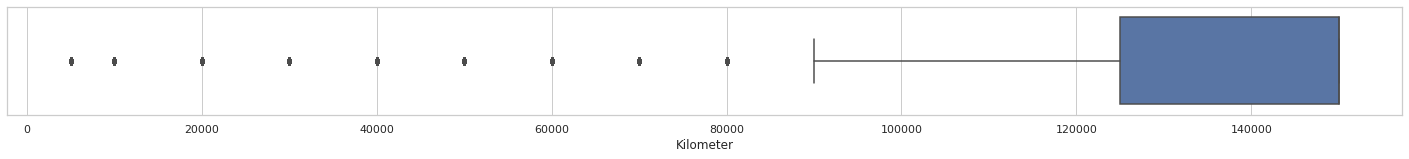

In [53]:
#Строим ящик с усами
plt.figure(figsize =(25, 2))
sns.boxplot(df['Kilometer']);

Аномалий не обнаружено. Выбросов немного и они выглядят правдоподобно.

## Обучение моделей

Выделим признаки и проведёи кодирование данных

In [54]:
#Удалим неинформативные признаки
df = df.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

In [55]:
#Преобразуем значения столбца 'Repaired' в 0 и 1
df['Repaired'] = df['Repaired'].map({'yes': 1, 'no': 0})

In [56]:
#Выделим признаки и целевой признак
features = df.drop(['Price'], axis=1)
target = df['Price']

In [57]:
#Выделим обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=12345)

In [58]:
#Выделим категориальные признаки для кодирования
#Repaired кодировать не нужно
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand']

In [59]:
#Выделим численные признаки
num_features = ['RegistrationYear', 'Power', 'Kilometer']

Подготовим выборки для OHE

In [60]:
#Создадим выборки для OHE
X_train_ohe = X_train.copy()
X_test_ohe = X_test.copy()

In [61]:
#Создаём коировщики
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False, dtype=np.int8)

In [62]:
%%time

# обучаем кодировщики на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(X_train_ohe[cat_features])

CPU times: user 46.5 ms, sys: 7.98 ms, total: 54.5 ms
Wall time: 53.7 ms


OneHotEncoder(drop='first', dtype=<class 'numpy.int8'>, handle_unknown='ignore',
              sparse=False, sparse_output=False)

In [63]:
%%time

# добавляем закодированные признаки
X_train_ohe[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(X_train_ohe[cat_features])

CPU times: user 29.9 s, sys: 16.8 s, total: 46.7 s
Wall time: 46.8 s


In [64]:
# удаляем незакодированные категориальные признаки (изначальные колонки)
X_train_ohe = X_train_ohe.drop(cat_features, axis=1)

In [65]:
# создаём скелер
scaler = StandardScaler()

# обучаем его на численных признаках тренировочной выборки и сразу трансформируем её
X_train_ohe[num_features] = scaler.fit_transform(X_train_ohe[num_features])

In [66]:
# смотрим на результат
X_train_ohe.head()

,RegistrationYear,Power,Kilometer,Repaired,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo
323547,0.532233,-0.436586,0.56892,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
323373,0.375132,0.409297,0.56892,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
282444,-0.567476,-1.403311,0.56892,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
250228,-0.881678,-1.242190,0.56892,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
235361,-0.410375,0.469717,0.56892,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
#Аналогично трансформируем тестовую выборку
# добавляем закодированные признаки в X_test_model
X_test_ohe[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(X_test_ohe[cat_features])

In [68]:
# удаляем незакодированные категориальные признаки (изначальные колонки)
X_test_ohe = X_test_ohe.drop(cat_features, axis=1)

In [69]:
# скелером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, масштабируем тестовую
X_test_ohe[num_features] = scaler.transform(X_test_ohe[num_features])

In [70]:
# смотрим на результат
X_test_ohe.head()

,RegistrationYear,Power,Kilometer,Repaired,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo
290772,-0.253273,0.228036,0.568920,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
145380,0.375132,0.872519,0.568920,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
225385,1.631942,-0.295606,-2.666452,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
61354,0.846436,1.557282,-0.105115,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
276844,-0.096172,-0.194905,0.568920,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Подготовим выборки для OE

In [71]:
#Создаём кодировщик
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [72]:
#Обучаем его на трен. выборке
encoder.fit(X_train)

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [73]:
#Преобразуем трен.в. 
X_train_oe = encoder.transform(X_train)

In [74]:
#Оформим таблицу
X_train_oe = pd.DataFrame(encoder.transform(X_train), columns=X_train.columns)

In [75]:
# обучаем scaler на численных признаках тренировочной выборки и сразу трансформируем её
X_train_oe[num_features] = scaler.fit_transform(X_train_oe[num_features])

In [76]:
#Смотрим на результат
X_train_oe

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,5.0,0.532233,1.0,-0.479368,149.0,0.493165,5.0,27.0,0.0
1,0.0,0.375132,1.0,0.563462,201.0,0.493165,5.0,38.0,0.0
2,5.0,-0.567476,1.0,-1.704961,143.0,0.493165,5.0,38.0,0.0
3,5.0,-0.881678,1.0,-1.457692,224.0,0.493165,5.0,27.0,0.0
4,4.0,-0.410375,1.0,0.627967,59.0,0.493165,5.0,20.0,0.0
...,...,...,...,...,...,...,...,...,...
259392,5.0,-1.195881,1.0,-0.253600,83.0,-4.040510,5.0,24.0,0.0
259393,4.0,-1.352982,1.0,-0.253600,116.0,0.493165,5.0,38.0,0.0
259394,5.0,-2.138488,1.0,-0.253600,173.0,-2.907091,5.0,38.0,0.0
259395,7.0,-0.253273,1.0,0.627967,11.0,0.493165,5.0,2.0,1.0


In [77]:
#Преобразуем тест.в.
X_test_oe = encoder.transform(X_train)

In [78]:
#Оформим таблицу
X_test_oe = pd.DataFrame(encoder.transform(X_test), columns=X_test.columns)

In [79]:
# скелером, который обучен на трен.в., масштабируем тестовую
X_test_oe[num_features] = scaler.transform(X_test_oe[num_features])

In [80]:
#Смотрим на результат
X_test_oe

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,7.0,-0.253273,1.0,0.380698,170.0,0.493165,5.0,38.0,0.0
1,4.0,0.375132,1.0,1.004245,11.0,0.493165,5.0,2.0,0.0
2,4.0,1.631942,1.0,-0.253600,116.0,-2.907091,5.0,38.0,1.0
3,7.0,0.846436,0.0,1.595541,15.0,0.115359,5.0,2.0,0.0
4,0.0,-0.096172,1.0,-0.113840,112.0,0.493165,5.0,10.0,0.0
...,...,...,...,...,...,...,...,...,...
86461,0.0,1.789043,1.0,0.047423,198.0,-3.662704,5.0,27.0,0.0
86462,4.0,0.846436,0.0,1.477282,31.0,0.493165,5.0,1.0,0.0
86463,7.0,-0.881678,1.0,-0.253600,119.0,-3.284898,5.0,12.0,0.0
86464,7.0,-0.724577,1.0,0.047423,103.0,0.493165,5.0,10.0,0.0


In [81]:
#Удалим ненужные переменные
del df, features, target, brands, vehicle_types

Проведём обучение моделей

**Линейная регресссия**

In [82]:
model_lr = LinearRegression()

In [83]:
%%time
#Найдём время обучения модели

model_lr.fit(X_train_ohe, y_train)

CPU times: user 24.8 s, sys: 40.1 s, total: 1min 4s
Wall time: 1min 4s


LinearRegression()

In [84]:
%%time

#Найдём значение метрики RMSE с помощью кросс-валидации
final_scores = []
scores = cross_val_score(model_lr, X_train_ohe, y_train, scoring='neg_root_mean_squared_error', cv=5)
final_scores.append(scores.mean())

final_rmse = pd.Series(final_scores).mean()*(-1)
print('Среднее значение метрики RMSE:', final_rmse)

Среднее значение метрики RMSE: 2719.234801465992
CPU times: user 1min 25s, sys: 2min 30s, total: 3min 55s
Wall time: 3min 56s


In [85]:
%%time

#Найдём время предсказания
predicted_lr = model_lr.predict(X_train_ohe)

CPU times: user 232 ms, sys: 182 ms, total: 414 ms
Wall time: 400 ms


**Ridge**

Подберём гиперпараметры модели Ridge с помощью GridSearchCV

In [86]:
%%time

# Объявляем модель
model_ridge = Ridge(random_state=12345)

# словарь с гиперпараметрами и значениями, которые хотим перебрать
param_grid_ridge = {'alpha': np.arange(0, 0.21, 0.01)}

gs_ridge = GridSearchCV(
    model_ridge, 
    param_grid=param_grid_ridge, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1
)

gs_ridge.fit(X_train_ohe, y_train)

# лучшее значение RMSE на кросс-валидации
print(f'best RMSE: {gs_ridge.best_score_ * -1}')

# лучшие гиперпараметры
print(f'Гиперпараметры: {gs_ridge.best_params_}')

best RMSE: 2719.218234435798
Гиперпараметры: {'alpha': 0.2}
CPU times: user 2min 59s, sys: 2min 27s, total: 5min 27s
Wall time: 5min 27s


Найдём время обучения модели Ridge

In [87]:
model_ridge = Ridge(alpha=0.2, random_state=12345)

In [88]:
%%time

model_ridge.fit(X_train_ohe, y_train)

CPU times: user 1.44 s, sys: 635 ms, total: 2.08 s
Wall time: 2.1 s


Ridge(alpha=0.2, random_state=12345)

In [89]:
%%time

#Найдём время предсказания
predicted_ridge = model_ridge.predict(X_train_ohe)

CPU times: user 250 ms, sys: 159 ms, total: 409 ms
Wall time: 397 ms


**RandomForestRegressor**

Подберём гиперпараметры модели RandomForestRegressor с помощью GridSearchCV

In [90]:
%%time

# Объявляем модель
model_rf = RandomForestRegressor(random_state=12345)

# словарь с гиперпараметрами и значениями, которые хотим перебрать
# Указал небольшой диапазон, т.к. модель очень долго обучается
param_grid_rf = {'n_estimators': np.arange(20, 101, 20), 'max_depth': np.arange(10, 31, 10),}

gs_rf = GridSearchCV(
    model_rf, 
    param_grid=param_grid_rf, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1
)

gs_rf.fit(X_train_oe, y_train)

# лучшее значение RMSE на кросс-валидации
print(f'best_score: {gs_rf.best_score_ * -1}')

# лучшие гиперпараметры
print(f'best_params: {gs_rf.best_params_}')

best_score: 1684.2416270337137
best_params: {'max_depth': 20, 'n_estimators': 100}
CPU times: user 30min 18s, sys: 0 ns, total: 30min 18s
Wall time: 30min 19s


Найдём скорость обучения RandomForestRegressor

In [103]:
model_rf = RandomForestRegressor(n_estimators = 100, max_depth=20, random_state=12345)

In [104]:
%%time

model_rf.fit(X_train_oe, y_train)

CPU times: user 54.4 s, sys: 0 ns, total: 54.4 s
Wall time: 54.7 s


RandomForestRegressor(max_depth=20, random_state=12345)

In [105]:
%%time

#Найдём скорость предсказаний
predicted_rf = model_rf.predict(X_train_oe)

CPU times: user 6.76 s, sys: 0 ns, total: 6.76 s
Wall time: 6.76 s


**LGBMRegressor**

Подберём гиперпараметры модели LGBMRegressor с помощью GridSearchCV

In [106]:
%%time

model_lgb = LGBMRegressor(random_state=12345)

# словарь с гиперпараметрами и значениями, которые хотим перебрать
# Указал небольшой диапазон, т.к. модель очень долго обучается
param_grid_lgb = {'n_estimators': np.arange(20, 101, 20), 'max_depth': np.arange(10, 31, 10),}

gs_lgb = GridSearchCV(
    model_lgb, 
    param_grid=param_grid_lgb, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1
)

gs_lgb.fit(X_train_oe, y_train)

# лучшее значение RMSE на кросс-валидации
print(f'best RMSE: {gs_lgb.best_score_ * -1}')

# лучшие гиперпараметры
print(f'Гиперпараметы: {gs_lgb.best_params_}')

best RMSE: 1785.006641075723
Гиперпараметы: {'max_depth': 20, 'n_estimators': 100}
CPU times: user 1h 26min 4s, sys: 0 ns, total: 1h 26min 4s
Wall time: 1h 26min 10s


Найдём скорость обучения LGBMRegressor

In [107]:
model_lgb = LGBMRegressor(n_estimators=100, max_depth=20, random_state=12345)

In [108]:
%%time

model_lgb.fit(X_train_oe, y_train)

CPU times: user 6min 16s, sys: 0 ns, total: 6min 16s
Wall time: 6min 16s


LGBMRegressor(max_depth=20, random_state=12345)

In [109]:
%%time

#Найдём скорость предсказаний
predicted_lgb = model_lgb.predict(X_train_oe)

CPU times: user 1.96 s, sys: 0 ns, total: 1.96 s
Wall time: 1.88 s


**CatBoostRegressor**

Подберём гиперпараметры модели CatBoosterRegressor с помощью GridSearchCV

In [111]:
%%time

#Объявим модель со встроенным методом кодирования категориальных признаков
model_cb = CatBoostRegressor(verbose=False, cat_features=cat_features, random_state=12345)

# словарь с гиперпараметрами и значениями, которые хотим перебрать
param_grid_cb = {'n_estimators': np.arange(20, 201, 20), 'max_depth': np.arange(10, 101, 10),}

gs_cb = GridSearchCV(
    model_cb, 
    param_grid=param_grid_cb, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1
)

gs_cb.fit(X_train, y_train)

# лучшее значение RMSE на кросс-валидации
print(f'best RMSE: {gs_cb.best_score_ * -1}')

# лучшие гиперпараметры
print(f'Гиперпараметы: {gs_cb.best_params_}')

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

best RMSE: 1659.2932515691468
Гиперпараметы: {'max_depth': 10, 'n_estimators': 200}
CPU times: user 18min 12s, sys: 0 ns, total: 18min 12s
Wall time: 19min 30s


Найдём скорость обучения CatBoostRegressor

In [112]:
model_cb = CatBoostRegressor(n_estimators=200, max_depth=10, verbose=False, cat_features=cat_features, random_state=12345)

In [113]:
%%time

model_cb.fit(X_train, y_train)

CPU times: user 1min 30s, sys: 0 ns, total: 1min 30s
Wall time: 1min 31s


In [114]:
%%time

#Найдём скорость предсказаний
predicted_cb = model_cb.predict(X_train)

CPU times: user 952 ms, sys: 0 ns, total: 952 ms
Wall time: 962 ms


Модели "Линейная регрессия" и "Ridge" показали метрику RMSE больее 2500, что не удовлетворяет условиям задачи. Данные по остальным моделям занесём в таблицу

In [135]:
models_data = pd.DataFrame([['RandomForestRegressor','1684','0.54','6.76'],
                            ['LGBMRegressor','1785','6.16', '1.88'],
                            ['CatBoostRegressor','1659','1.31', '0.962']],
                           columns=['Модель', 'RMSE', 'Время обучения, мин.сек', 'Скорость предсказания, сек'])

In [141]:
print('Модели в порядке убывани метрики RMSE')
display(models_data.sort_values(by='RMSE').reset_index(drop=True))
print('Модели в порядке возрастания времени обучения')
display(models_data.sort_values(by='Время обучения, мин.сек').reset_index(drop=True))

Модели в порядке убывани метрики RMSE


,Модель,RMSE,"Время обучения, мин.сек","Скорость предсказания, сек"
0,CatBoostRegressor,1659,1.31,0.962
1,RandomForestRegressor,1684,0.54,6.76
2,LGBMRegressor,1785,6.16,1.88


Модели в порядке возрастания времени обучения


,Модель,RMSE,"Время обучения, мин.сек","Скорость предсказания, сек"
0,RandomForestRegressor,1684,0.54,6.76
1,CatBoostRegressor,1659,1.31,0.962
2,LGBMRegressor,1785,6.16,1.88


**Вывод**: Минимальный показатель RMSE = 1659 на валидационной выборке показал модель **CatBoostRegressor**, а минимальное время обучения - 54 сек. показала модель **RandomForestRegressor**. Разница в скорости предсказаний для всех моделей несущественна.<br>

## Анализ моделей

Протестируем модель **CatBoostRegressor** как модель с мин. RMSE на тестовой выборке

In [142]:
predicted_cb = model_cb.predict(X_test)

In [143]:
print("RMSE =", mean_squared_error(y_test, predicted_cb) ** 0.5)

RMSE = 1654.982190089888


Протестируем модель **RandomForestRegressor** как модель с мин. временем обучения на тестовой выборке

In [144]:
predicted_ridge = model_rf.predict(X_test_oe)

In [145]:
print("RMSE =", mean_squared_error(y_test, predicted_ridge) ** 0.5)

RMSE = 1675.494046182557


**Вывод**: Метрика RMSE моделей на тестовой выборке незначительно отличается от валдиационной, значит, обучение моделей прошло корректно.

## Общий вывод

По условиям задачи необходимо было построить модель для определения рыночной стоимости автомобиля по следующим известным характеристикам:
- Марка автомобиля<br>
- Модель автомобиля<br>
- Год регистрации автомобиля<br>
- Тип коробки передач<br>
- Мощность (л. с.)<br>
- Пробег (км)<br>
- Тип топлива<br>
- Была машина в ремонте или нет<br>

Для обучения модели были доступны исторические данные: технические характеристики, комплектации и цены автомобилей.<br>

В ходе работы были проведёны этапы
1. Анализ данных
2. Подготовка данных для обучения моделей
3. Обучиние нескольких моделей и сравнение их характеристик:
    - Качества предсказания
    - Скорости предсказания
    - Времени обучения

## Чек-лист проверки